In [1]:
# Imports

import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Function to sort the MNIST dataset, as fetch_openml returns it unsorted

def sort_by_target(mnist):
    
    # The training and test sets are separately sorted
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    
    # The instances and their labels are sorted so that they still match
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
# Fetch the MNIST dataset and sort it

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml returns the labels as strings, so we convert them to integers
    sort_by_target(mnist) # The dataset is sorted
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original') # The old function fetch_mldata is used if fetch_openml fails

# The datasets characteristics are shown for inspection
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [5]:
y.shape

(70000,)

<function matplotlib.pyplot.show(*args, **kw)>

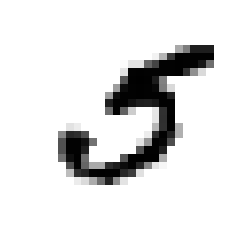

In [6]:
# One of the digits and its label is displayed as an example

some_digit = x[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show

In [7]:
y[36000]

5

In [8]:
# The dataset is split into a training set and test set

x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [9]:
# The training set is randomly shuffled

shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

In [10]:
# Binary classifier

# Target vectors are defined

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
# Train a SGD classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=-np.infty)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# Check the classifier on the example digit

sgd_clf.predict([some_digit])

array([False])

In [13]:
# Measure the accuracy of the classifier with cross-validation

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.96575, 0.96425, 0.96325])

In [14]:
# Train a classifier to classify every single non-5 image

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [15]:
# Measure the accuracy of the classifier with cross-validation

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.90985, 0.90865, 0.91045])

In [16]:
# Obtain predictions from cross-validation

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [17]:
# Obtain confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53826,   753],
       [ 1382,  4039]], dtype=int64)

In [18]:
# Obtain confusion matrix for a perfect classifier

y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [19]:
# Compute precision, recall and the F1 score

from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred)

0.8428631051752922

In [20]:
recall_score(y_train_5, y_train_pred)

0.7450654860726803

In [21]:
f1_score(y_train_5, y_train_pred)

0.7909527073337902

In [22]:
# Change the threshold and observe results

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-31477.89264028])

In [23]:
# Set a low threshold and check the example digit

threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
# Set a high threshold and check the example digit

threshold = 200000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
# Obtain decision scores from cross-validation

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
y_scores.shape

(60000,)

In [28]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

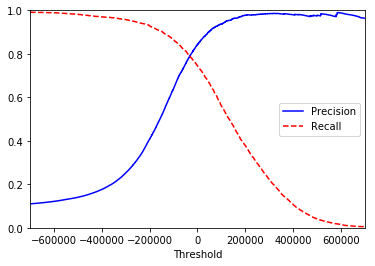

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "r--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    plt.ylim([0,1])
    plt.xlim([-700000, 700000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

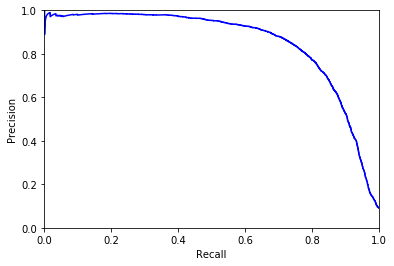

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [31]:
y_train_pred_90 = (y_scores > 70000)

precision_score(y_train_5, y_train_pred_90)

0.9208378672470077

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.6244235380926029

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

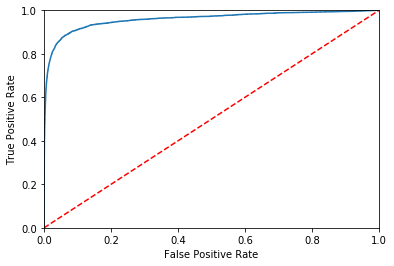

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], 'r--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9591139108551726

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [37]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

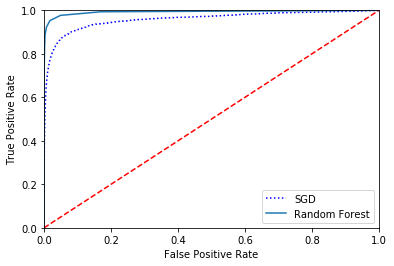

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9927980747291439

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

precision_score(y_train_5, y_train_pred_forest)

0.9826792370094277

In [44]:
recall_score(y_train_5, y_train_pred_forest)

0.8267847260653016

In [45]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-243434.76311469, -521776.31072728, -246554.85936954,
        -158179.45684771, -518449.45115686,  -31477.89264028,
        -645134.43570007, -280928.94273169, -617313.80241531,
        -663403.3423231 ]])

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [50]:
sgd_clf.classes_[5]

5

In [51]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=5, tol=-np.infty))
ovo_clf.fit(x_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [52]:
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [53]:
len(ovo_clf.estimators_)

45

In [54]:
forest_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [55]:
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [56]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [57]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.88097381, 0.8720436 , 0.85337801])

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91026795, 0.9079954 , 0.91038656])

In [59]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5743,    2,   21,    9,   11,   45,   40,    8,   41,    3],
       [   2, 6455,   46,   23,    6,   46,    6,   14,  133,   11],
       [  50,   37, 5329,  112,   76,   26,   81,   62,  170,   15],
       [  39,   37,  141, 5333,    5,  241,   32,   54,  153,   96],
       [  21,   24,   38,    7, 5374,    9,   46,   29,   93,  201],
       [  67,   40,   36,  182,   75, 4607,  103,   30,  190,   91],
       [  38,   29,   50,    3,   47,   81, 5616,    4,   50,    0],
       [  25,   25,   69,   31,   56,   12,    3, 5777,   15,  252],
       [  50,  143,   68,  156,   19,  156,   52,   27, 5054,  126],
       [  42,   32,   29,   89,  159,   32,    2,  193,   86, 5285]],
      dtype=int64)

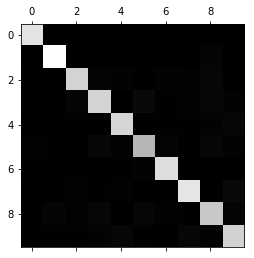

In [60]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

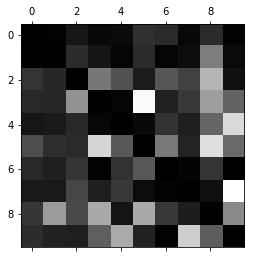

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [66]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

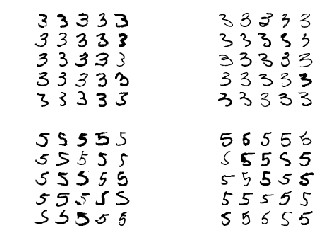

In [67]:
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
plt.show()

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [69]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
noise = rnd.randint(0, 100, (len(x_train), 784))
noise = rnd.randint(0, 100, (len(x_test), 784))
x_train_mod = x_train + noise
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)